In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd().replace("notebooks/pruning_quantization", "")))

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from config import Config
from data.dataset import NetworkDataset, load_datasets, get_subset
from model_config import MLP_Models, LSTM_Models, GRU_Models, CNN_models
from utils.benchmark import Benchmark
from compact.pruning import prune_mlp_model, prune_rnn_model, prune_cnn_model
from compact.quantization import dynamic_quantize, static_quantization
import copy
import warnings
warnings.filterwarnings("ignore")

In [2]:
conf = Config()
#load_model = MLP_Models()
#load_model = LSTM_Models()
#load_model = GRU_Models()
load_model = CNN_models()
model_conf = load_model.cnn_4
model = load_model.get_model(model_conf)
model.load()
print(conf.device)

Checkpoint loaded from /global/D1/homes/jorgetf/Network-Packet-ML-Model/checkpoint/large_model/cnn_4.pth!
cpu


In [3]:
# data loader
X_train, y_train, X_val, y_val, X_test, y_test = load_datasets(conf.datasets, model_type=load_model.type)

# create train dataloader
train_dataset = NetworkDataset(X_train, y_train)

# create test dataloader
dataset = NetworkDataset(X_test, y_test)
subset, length = get_subset(dataset, y_test)
loader = DataLoader(subset, conf.batch_size, shuffle=True)
assert conf.batch_size < length

train_dataset_no_aug = copy.deepcopy(train_dataset)
calibration_loader = DataLoader(train_dataset_no_aug, batch_size=conf.batch_size, shuffle=False)

In [4]:
# prune model
checkpoint_path = os.path.join(conf.checkpoint, "pruned_quantized", "pruned_" + model_conf["name"] + ".pth")
model.checkpoint_path = checkpoint_path

# new hidden sizes
if load_model.type == "mlp":
    pruned_model = prune_mlp_model(model.model, prune_ratio=0.4)
elif load_model.type == "rnn":
    pruned_model = prune_rnn_model(model.model, prune_ratio=0.4)
elif load_model.type == "cnn":
    pruned_model = prune_cnn_model(model.model, prune_ratio=0.4)
else:
    raise ValueError("model type must be 'mlp', 'rnn' or 'cnn'!")
    

model.model = pruned_model.to(conf.device)
model.optimizer = torch.optim.AdamW(
    model.model.parameters(), 
    lr=conf.learning_rate, 
    weight_decay=conf.weight_decay
)
model.scheduler = torch.optim.lr_scheduler.ExponentialLR(
    model.optimizer, 
    gamma=conf.gamma
)
model.load()

Checkpoint loaded from /global/D1/homes/jorgetf/Network-Packet-ML-Model/checkpoint/pruned_quantized/pruned_cnn_4.pth!


In [ ]:
fp32_model = model.model
fp32_model.cpu()
fp32_model.eval()

if load_model.type == "rnn":
    int8_model = dynamic_quantize(fp32_model, arch="arm")

else:
    if load_model.type == "mlp":
        fp32_modules = ["embedding", "ln1", "output"] # mlp modules
        example_input = torch.randn(1, 513) # mlp
    elif load_model.type == "cnn":
        fp32_modules = ["embedding", "ln1", "ln2", "output"] # cnn modules
        example_input = torch.randn(1, 1, 513) # cnn
    else:
        raise ValueError("Model type not recognized!")
    
    int8_model = static_quantization(fp32_model, calibration_loader, fp32_modules, example_input, arch="arm")

In [6]:
print(int8_model)
model.model = int8_model

GraphModule(
  (conv): Module(
    (0): Module(
      (0): QuantizedConv1d(1, 19, kernel_size=(23,), stride=(1,), scale=1.352432370185852, zero_point=57)
      (1): QuantizedLeakyReLU(negative_slope=0.01)
      (2): QuantizedDropout(p=0.2, inplace=False)
    )
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Module(
      (0): QuantizedConv1d(19, 38, kernel_size=(19,), stride=(1,), scale=0.5066348314285278, zero_point=78)
      (1): QuantizedLeakyReLU(negative_slope=0.01)
      (2): QuantizedDropout(p=0.2, inplace=False)
    )
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Module(
      (0): QuantizedConv1d(38, 76, kernel_size=(15,), stride=(1,), scale=0.1620202213525772, zero_point=79)
      (1): QuantizedLeakyReLU(negative_slope=0.01)
      (2): QuantizedDropout(p=0.2, inplace=False)
    )
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Module(
      

Warmup Done!
Memory Benchmark Done!


ERROR:2026-01-29 17:24:45 3913231:3913231 DeviceProperties.cpp:47] gpuGetDeviceCount failed with code 35


Latency Benchmark Done!
Throughput Benchmark Done!
CPU Benchmark Done!
Metrics Benchmark Done!


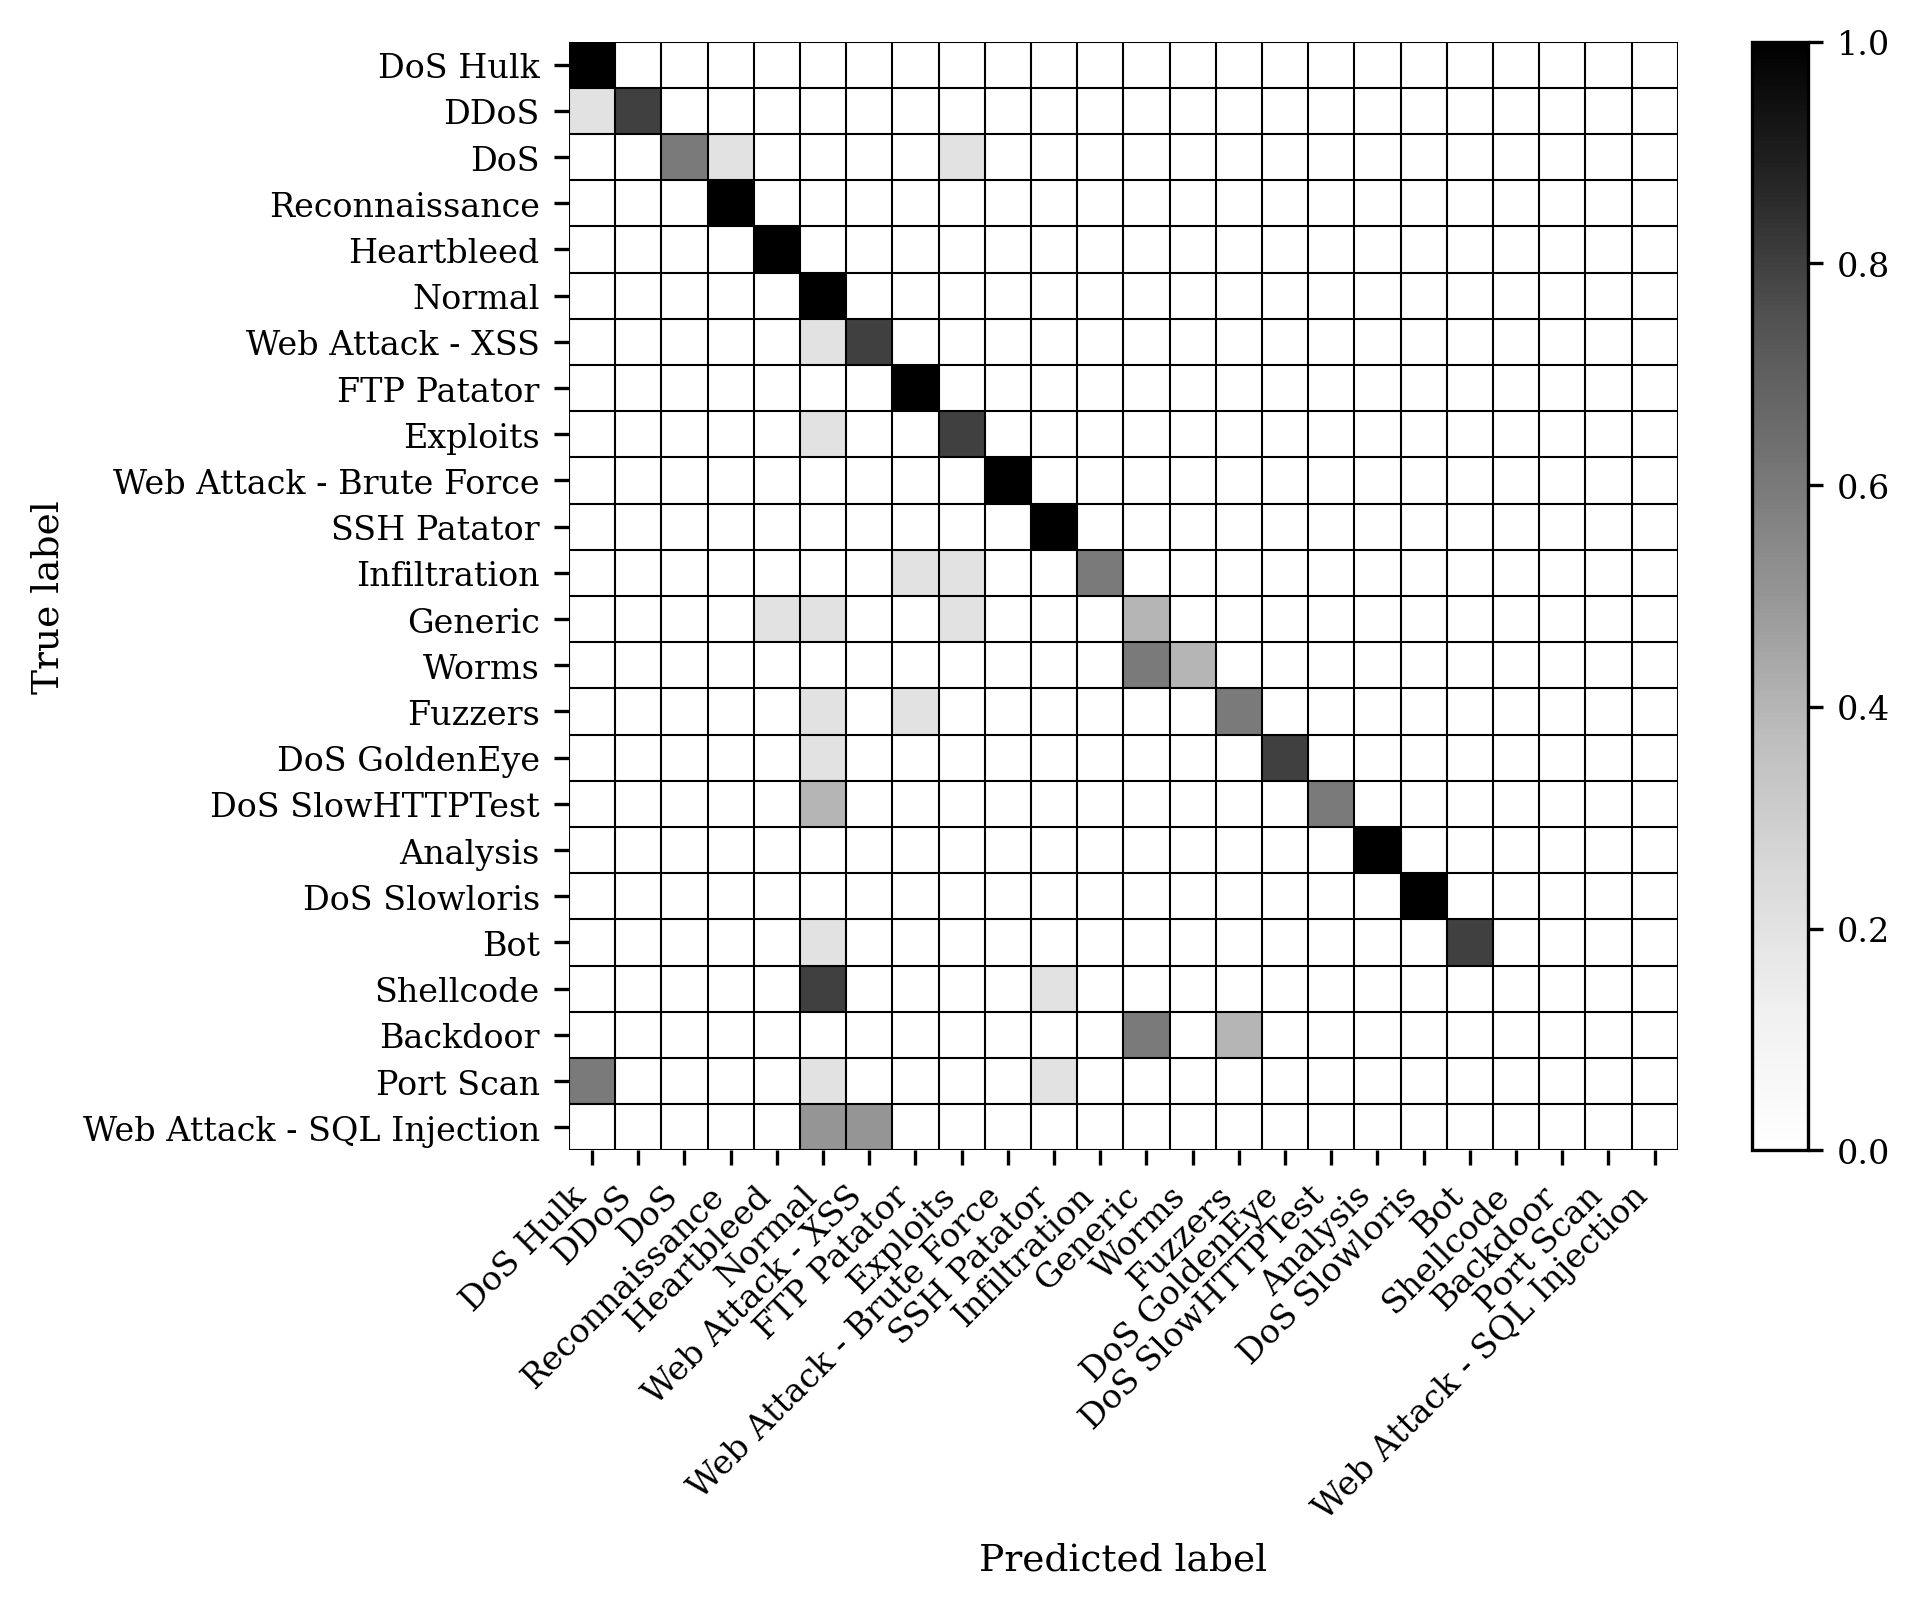

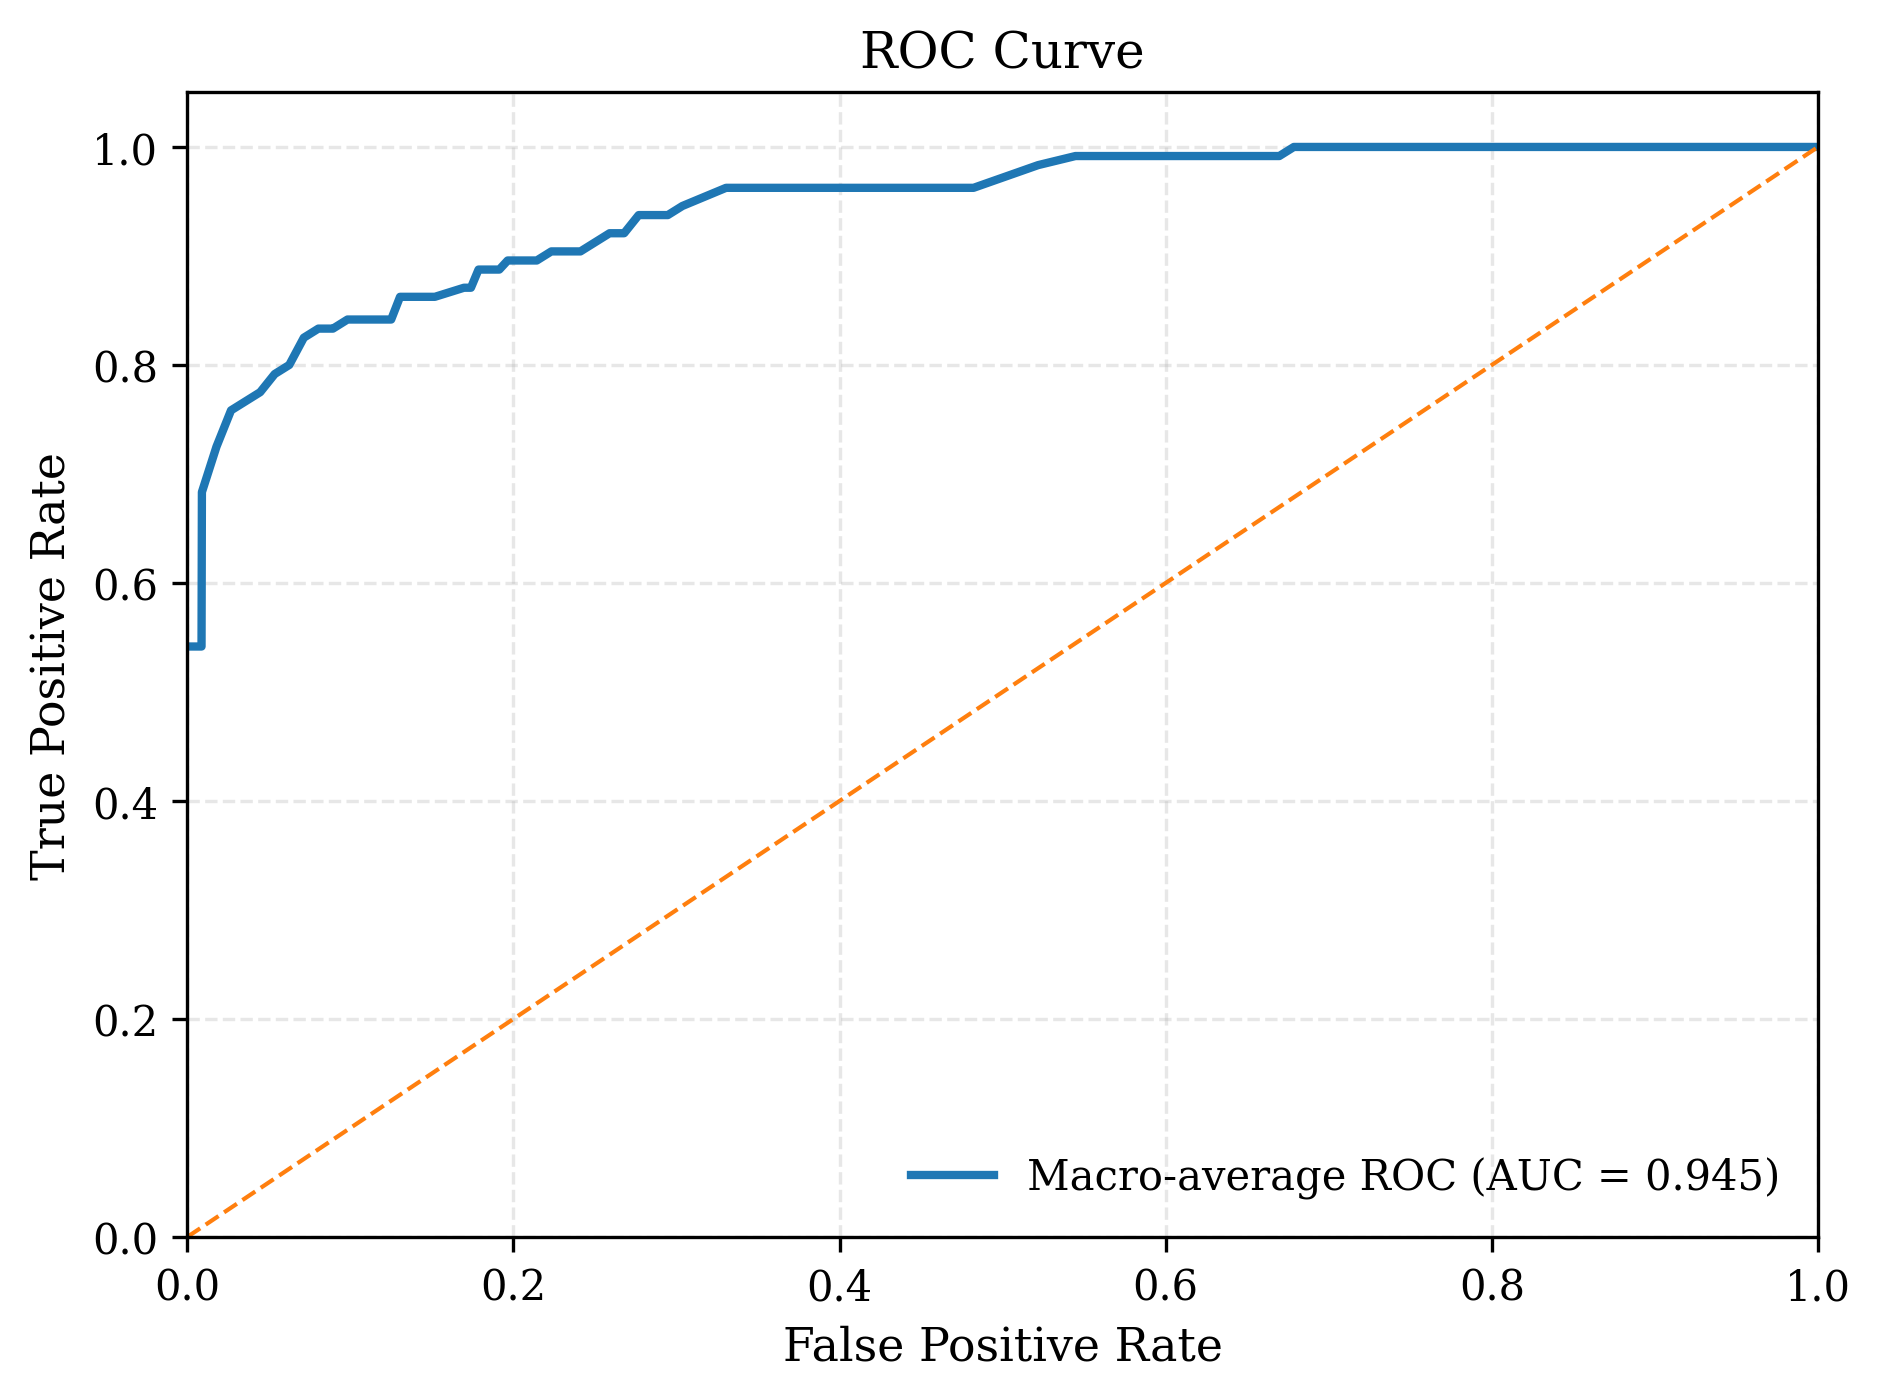

,Section,Metric,Value
0,Info,Name,pruned_quant_cnn_4
1,Info,Batch Size,1
2,Info,Samples,117
3,Info,Location,Host
4,Memory,Avg. (MB),0.075
5,Memory,Peak (MB),1.401
6,Memory,Model (MB),0.031
7,Latency,Total (ms),162.450
8,Latency,Avg. (ms),1.388
9,Latency,Min (ms),1.259


In [ ]:
# benchmark model
name = "pruned_quant_" + model_conf["name"]
result_path = os.path.join(conf.benchmark_dpu, "pruned_quantized_model", name + ".csv")
plot_path = os.path.join(conf.plot, conf.location, "pruned_quantized_model")

benchmark = Benchmark(model, loader, conf.batch_size, name, result_path, runs=length)
benchmark(plot=True, plot_path=plot_path)

# print and save result
benchmark.print_result()
benchmark.save()